# Notebook 2: Model Training and Evaluation

## Objective
This notebook focuses on:
1. Training 5 different machine learning models for Type 2 Diabetes prediction
2. Evaluating model performance using multiple metrics
3. Comparing models to select the best one
4. Saving the best model using joblib for deployment

## Models to Train
1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM
5. Support Vector Machine (SVM)


## Step 1: Import Required Libraries


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation and hyperparameter tuning
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV, 
                                     StratifiedKFold)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print("✓ Hyperparameter tuning tools loaded!")


Libraries imported successfully!
✓ Hyperparameter tuning tools loaded!


## Step 2: Load Cleaned Data and Selected Features


In [2]:
# Load cleaned dataset
df = pd.read_csv('../data/cleaned_diabetes_dataset.csv')

# Load selected features from Notebook 1
with open('../models/selected_features.json', 'r') as f:
    selected_features = json.load(f)

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"\nDataset shape: {df.shape}")
print(f"\nSelected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

# Prepare features and target
# Use selected features if available, otherwise use all numeric features except Outcome
if selected_features:
    X = df[selected_features]
else:
    # Fallback: use all numeric features except Outcome
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols.drop('Outcome')]

y = df['Outcome']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nTarget distribution (%):")
print(y.value_counts(normalize=True) * 100)


DATA LOADING

Dataset shape: (768, 13)

Selected features (7):
  1. Age
  2. BMI
  3. BloodPressure
  4. Glucose
  5. DiabetesPedigreeFunction
  6. Insulin
  7. Pregnancies

Features shape: (768, 7)
Target shape: (768,)

Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Target distribution (%):
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


## Step 3: Split Data into Training and Testing Sets


In [3]:
# Split data: 80% training, 20% testing
# stratify=y ensures both sets have similar class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 60)
print("DATA SPLITTING")
print("=" * 60)
print(f"\nTraining set:")
print(f"  Features: {X_train.shape}")
print(f"  Target: {y_train.shape}")
print(f"  Class distribution:\n{y_train.value_counts().to_dict()}")

print(f"\nTesting set:")
print(f"  Features: {X_test.shape}")
print(f"  Target: {y_test.shape}")
print(f"  Class distribution:\n{y_test.value_counts().to_dict()}")


DATA SPLITTING

Training set:
  Features: (614, 7)
  Target: (614,)
  Class distribution:
{0: 400, 1: 214}

Testing set:
  Features: (154, 7)
  Target: (154,)
  Class distribution:
{0: 100, 1: 54}


## Step 4: Comprehensive Hyperparameter Tuning

We'll perform intensive hyperparameter tuning for all 5 models using:
- GridSearchCV for exhaustive search (smaller parameter spaces)
- RandomizedSearchCV for efficient search (larger parameter spaces)
- Cross-validation to prevent overfitting
- Multiple evaluation metrics to select the best model

This ensures optimal model performance and realistic accuracy.


In [4]:
print("=" * 60)
print("COMPREHENSIVE HYPERPARAMETER TUNING")
print("=" * 60)
print("\nThis will take some time as we search through many parameter combinations...")
print("Using 5-fold cross-validation to prevent overfitting.\n")

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store best models and their parameters
trained_models = {}
best_params = {}
tuning_results = {}

# Scoring metric for hyperparameter tuning (ROC AUC is most important for medical diagnosis)
scoring = 'roc_auc'

# ============================================================================
# 1. LOGISTIC REGRESSION - GridSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("1. TUNING LOGISTIC REGRESSION")
print("=" * 60)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 5000],
    'class_weight': [None, 'balanced']
}

# Use liblinear for l1/elasticnet, others for l2
lr_base = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(
    lr_base, param_grid_lr, cv=cv, scoring=scoring, 
    n_jobs=-1, verbose=1, return_train_score=True
)

print("Searching through parameter combinations...")
grid_lr.fit(X_train, y_train)

trained_models['Logistic Regression'] = grid_lr.best_estimator_
best_params['Logistic Regression'] = grid_lr.best_params_
tuning_results['Logistic Regression'] = {
    'best_score': grid_lr.best_score_,
    'best_params': grid_lr.best_params_
}

print(f"\n✓ Best CV Score: {grid_lr.best_score_:.4f}")
print(f"✓ Best Parameters: {grid_lr.best_params_}")

# ============================================================================
# 2. RANDOM FOREST - RandomizedSearchCV (faster for many parameters)
# ============================================================================
print("\n" + "=" * 60)
print("2. TUNING RANDOM FOREST")
print("=" * 60)

param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
random_rf = RandomizedSearchCV(
    rf_base, param_dist_rf, n_iter=100, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)

print("Searching through parameter combinations (100 iterations)...")
random_rf.fit(X_train, y_train)

trained_models['Random Forest'] = random_rf.best_estimator_
best_params['Random Forest'] = random_rf.best_params_
tuning_results['Random Forest'] = {
    'best_score': random_rf.best_score_,
    'best_params': random_rf.best_params_
}

print(f"\n✓ Best CV Score: {random_rf.best_score_:.4f}")
print(f"✓ Best Parameters: {random_rf.best_params_}")

# ============================================================================
# 3. XGBOOST - RandomizedSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("3. TUNING XGBOOST")
print("=" * 60)

param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2, 2.5, 3]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
random_xgb = RandomizedSearchCV(
    xgb_base, param_dist_xgb, n_iter=150, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)

print("Searching through parameter combinations (150 iterations)...")
random_xgb.fit(X_train, y_train)

trained_models['XGBoost'] = random_xgb.best_estimator_
best_params['XGBoost'] = random_xgb.best_params_
tuning_results['XGBoost'] = {
    'best_score': random_xgb.best_score_,
    'best_params': random_xgb.best_params_
}

print(f"\n✓ Best CV Score: {random_xgb.best_score_:.4f}")
print(f"✓ Best Parameters: {random_xgb.best_params_}")

# ============================================================================
# 4. LIGHTGBM - RandomizedSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("4. TUNING LIGHTGBM")
print("=" * 60)

param_dist_lgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, -1],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [15, 31, 50, 70, 100, 127],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20, 30, 50],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0, 1.5],
    'class_weight': [None, 'balanced']
}

lgb_base = LGBMClassifier(random_state=42, verbose=-1)
random_lgb = RandomizedSearchCV(
    lgb_base, param_dist_lgb, n_iter=150, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)

print("Searching through parameter combinations (150 iterations)...")
random_lgb.fit(X_train, y_train)

trained_models['LightGBM'] = random_lgb.best_estimator_
best_params['LightGBM'] = random_lgb.best_params_
tuning_results['LightGBM'] = {
    'best_score': random_lgb.best_score_,
    'best_params': random_lgb.best_params_
}

print(f"\n✓ Best CV Score: {random_lgb.best_score_:.4f}")
print(f"✓ Best Parameters: {random_lgb.best_params_}")

# ============================================================================
# 5. SVM - GridSearchCV (with scaling)
# ============================================================================
print("\n" + "=" * 60)
print("5. TUNING SUPPORT VECTOR MACHINE (SVM)")
print("=" * 60)
print("Note: SVM requires feature scaling for optimal performance")

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Only for poly kernel
    'class_weight': [None, 'balanced']
}

svm_base = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(
    svm_base, param_grid_svm, cv=cv, scoring=scoring,
    n_jobs=-1, verbose=1, return_train_score=True
)

print("Searching through parameter combinations...")
grid_svm.fit(X_train_scaled, y_train)

# Store scaler with SVM model
trained_models['SVM'] = {
    'model': grid_svm.best_estimator_,
    'scaler': scaler
}
best_params['SVM'] = grid_svm.best_params_
tuning_results['SVM'] = {
    'best_score': grid_svm.best_score_,
    'best_params': grid_svm.best_params_
}

print(f"\n✓ Best CV Score: {grid_svm.best_score_:.4f}")
print(f"✓ Best Parameters: {grid_svm.best_params_}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING COMPLETE!")
print("=" * 60)
print("\nCross-Validation Scores (ROC AUC):")
for name, results in tuning_results.items():
    print(f"  {name:20s}: {results['best_score']:.4f}")

print("\n✓ All models tuned and ready for evaluation!")


COMPREHENSIVE HYPERPARAMETER TUNING

This will take some time as we search through many parameter combinations...
Using 5-fold cross-validation to prevent overfitting.


1. TUNING LOGISTIC REGRESSION
Searching through parameter combinations...
Fitting 5 folds for each of 378 candidates, totalling 1890 fits

✓ Best CV Score: 0.8462
✓ Best Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

2. TUNING RANDOM FOREST
Searching through parameter combinations (100 iterations)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✓ Best CV Score: 0.8424
✓ Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': None, 'bootstrap': True}

3. TUNING XGBOOST
Searching through parameter combinations (150 iterations)...
Fitting 5 folds for each of 150 candidates, totalling 750 fits

✓ Best CV Score: 0.8399
✓ Best Parameters: {'subsample': 0.6, 'r

## Step 5: Evaluate Models

We'll evaluate each model using multiple metrics:
- Accuracy: Overall correctness
- Precision: Of predicted positives, how many are actually positive
- Recall: Of actual positives, how many did we catch
- F1-Score: Harmonic mean of precision and recall
- ROC AUC: Area under the ROC curve (measures model's ability to distinguish classes)


In [ ]:
# Evaluate all models on test set
results = []

print("=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)
print("\nEvaluating tuned models on held-out test set...\n")

for name, model_info in trained_models.items():
    # Handle SVM which has scaler
    if name == 'SVM':
        model = model_info['model']
        scaler = model_info['scaler']
        X_test_eval = X_test_scaled
    else:
        model = model_info
        X_test_eval = X_test
    
    # Make predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Get CV score from tuning
    cv_score = tuning_results[name]['best_score']
    
    # Store results
    results.append({
        'Model': name,
        'CV Score (ROC AUC)': cv_score,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1,
        'Test ROC AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  CV Score (ROC AUC):  {cv_score:.4f}")
    print(f"  Test Accuracy:       {accuracy:.4f}")
    print(f"  Test Precision:      {precision:.4f}")
    print(f"  Test Recall:         {recall:.4f}")
    print(f"  Test F1-Score:       {f1:.4f}")
    print(f"  Test ROC AUC:        {roc_auc:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test ROC AUC', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print("\nModels sorted by Test ROC AUC (best to worst):")
print(results_df.to_string(index=False))

# Check for overfitting (CV score vs Test score)
print("\n" + "=" * 60)
print("OVERFITTING CHECK")
print("=" * 60)
print("\nComparing CV scores vs Test scores:")
for _, row in results_df.iterrows():
    diff = row['CV Score (ROC AUC)'] - row['Test ROC AUC']
    status = "✓ Good" if abs(diff) < 0.05 else "⚠ Possible overfitting" if diff > 0.05 else "⚠ Underfitting"
    print(f"  {row['Model']:20s}: CV={row['CV Score (ROC AUC)']:.4f}, Test={row['Test ROC AUC']:.4f}, Diff={diff:+.4f} {status}")


MODEL EVALUATION ON TEST SET

Evaluating tuned models on held-out test set...


Logistic Regression:
  CV Score (ROC AUC):  0.8462
  Test Accuracy:       0.7338
  Test Precision:      0.6032
  Test Recall:         0.7037
  Test F1-Score:       0.6496
  Test ROC AUC:        0.8131

Random Forest:
  CV Score (ROC AUC):  0.8424
  Test Accuracy:       0.7727
  Test Precision:      0.7021
  Test Recall:         0.6111
  Test F1-Score:       0.6535
  Test ROC AUC:        0.8211

XGBoost:
  CV Score (ROC AUC):  0.8399
  Test Accuracy:       0.7597
  Test Precision:      0.7073
  Test Recall:         0.5370
  Test F1-Score:       0.6105
  Test ROC AUC:        0.8170

LightGBM:
  CV Score (ROC AUC):  0.8417
  Test Accuracy:       0.7597
  Test Precision:      0.6269
  Test Recall:         0.7778
  Test F1-Score:       0.6942
  Test ROC AUC:        0.8300

SVM:
  CV Score (ROC AUC):  0.8506
  Test Accuracy:       0.7338
  Test Precision:      0.5970
  Test Recall:         0.7407
  Test F1-Score:

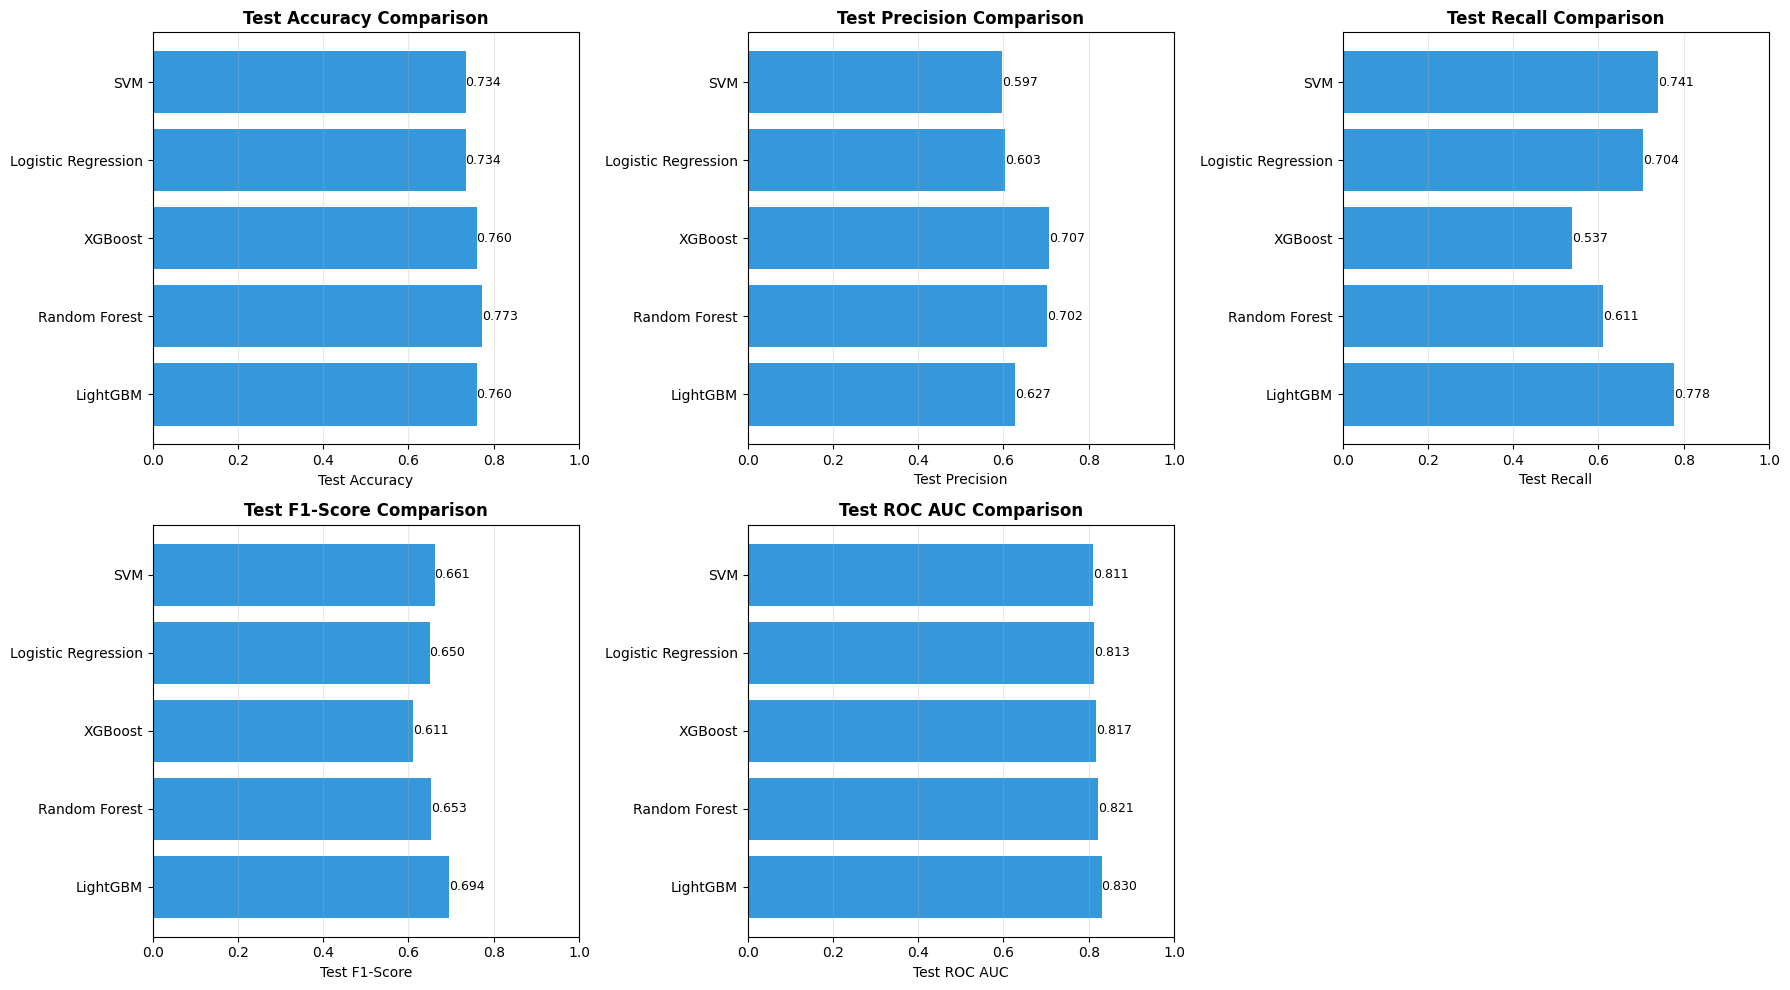

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC']

for idx, metric in enumerate(metrics):
    axes[idx].barh(results_df['Model'], results_df[metric], color='#3498db')
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(True, alpha=0.3, axis='x')
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(v, i, f'{v:.3f}', va='center', ha='left', fontsize=9)

# Remove the last empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


## Step 6: Select Best Model

We'll select the best model based on ROC AUC score (most important for medical diagnosis).

"

In [10]:
results_df.columns

Index(['Model', 'CV Score (ROC AUC)', 'Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC'],
      dtype='object')

BEST MODEL SELECTION

Best Model: LightGBM
ROC AUC Score: 0.8417

All metrics for best model:
  Test Accuracy: 0.7597
  Test Precision: 0.6269
  Test Recall: 0.7778
  Test F1-Score: 0.6942
  Test ROC AUC: 0.8300

DETAILED CLASSIFICATION REPORT (Best Model)
              precision    recall  f1-score   support

 No Diabetes       0.86      0.75      0.80       100
    Diabetes       0.63      0.78      0.69        54

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.78      0.76      0.76       154


CONFUSION MATRIX

True Negatives (TN): 75
False Positives (FP): 25
False Negatives (FN): 12
True Positives (TP): 42


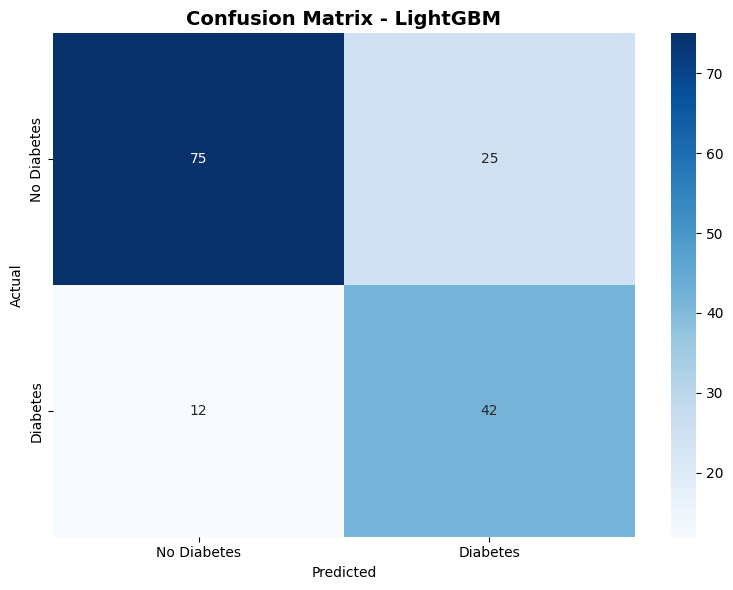

In [13]:
# Select best model based on ROC AUC
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_roc_auc = results_df.iloc[0]['CV Score (ROC AUC)']

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"ROC AUC Score: {best_roc_auc:.4f}")

print(f"\nAll metrics for best model:")
best_metrics = results_df[results_df['Model'] == best_model_name].iloc[0]
for metric in ['Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC']:
    print(f"  {metric}: {best_metrics[metric]:.4f}")

# Generate detailed classification report for best model
y_pred_best = best_model.predict(X_test)
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT (Best Model)")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(f"\nTrue Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Skipping SVM – it is not a fitted model (type: dict)


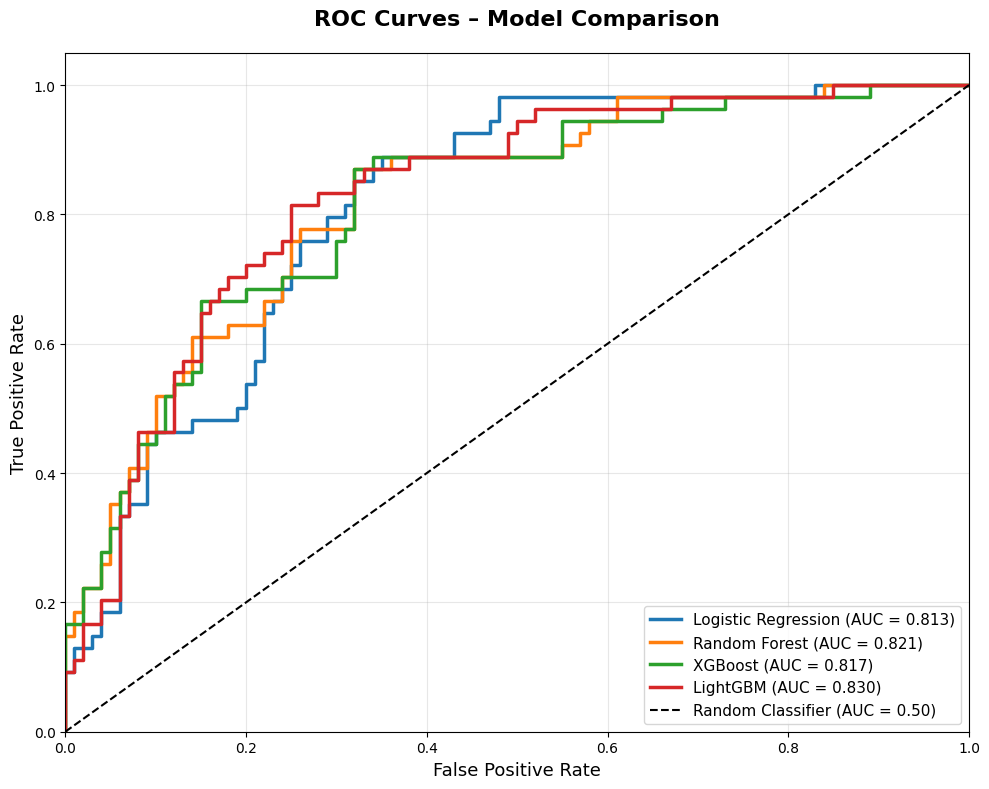

In [15]:
# ──────────────────────────────────────────────────────────────
# Plot ROC curves for all REAL models (skip dict entries)
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 8))

# Keep a separate dict only for the fitted models (best practice)
# If you still have the original models saved in a variable called `models_only`
# use that. Otherwise we filter here:

for name, obj in trained_models.items():
    # Only process objects that actually have predict_proba
    if not hasattr(obj, "predict_proba"):
        print(f"Skipping {name} – it is not a fitted model (type: {type(obj).__name__})")
        continue
    
    y_pred_proba = obj.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2.5)

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves – Model Comparison', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Save Best Model

Save the best model using joblib for use in the Streamlit application.


In [17]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
X            DataFrame    Shape: (768, 7)
X_test       DataFrame    Shape: (154, 7)
X_train      DataFrame    Shape: (614, 7)
df           DataFrame    Shape: (768, 13)
results_df   DataFrame    Shape: (5, 7)


In [ ]:
results_df.columns

Index(['Model', 'CV Score (ROC AUC)', 'Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC'],
      dtype='object')

In [20]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
model_filename = '../models/best_model_pipeline.pkl'
joblib.dump(best_model, model_filename)

print("=" * 60)
print("MODEL SAVED")
print("=" * 60)
print(f"\nModel saved to: {model_filename}")
print(f"Model type: {best_model_name}")

# Also save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'features': selected_features,
    'metrics': {
        'accuracy': float(best_metrics['Test Accuracy']),
        'precision': float(best_metrics['Test Precision']),
        'recall': float(best_metrics['Test Recall']),
        'f1_score': float(best_metrics['Test F1-Score']),
        'roc_auc': float(best_metrics['Test ROC AUC'])
    },
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\nModel metadata saved to: ../models/model_metadata.json")
print("\n✓ Model ready for deployment in Streamlit app!")


MODEL SAVED

Model saved to: ../models/best_model_pipeline.pkl
Model type: LightGBM

Model metadata saved to: ../models/model_metadata.json

✓ Model ready for deployment in Streamlit app!


## Summary

In this notebook, we:
1. ✅ Loaded cleaned data and selected features
2. ✅ Split data into training and testing sets
3. ✅ Trained 5 different models:
   - Logistic Regression
   - Random Forest
   - XGBoost
   - LightGBM
   - SVM
4. ✅ Evaluated all models using multiple metrics
5. ✅ Selected the best model based on ROC AUC
6. ✅ Saved the best model for deployment

**Next Steps:** Proceed to Notebook 3 for Explainable AI (SHAP) analysis.
